In [11]:
import ray
ray.init(ignore_reinit_error=True)

2020-07-28 06:54:49,763	ERROR worker.py:655 -- Calling ray.init() again after it has already been called.


Estimated Gaussian noise standard deviation = 0.5515405798531341


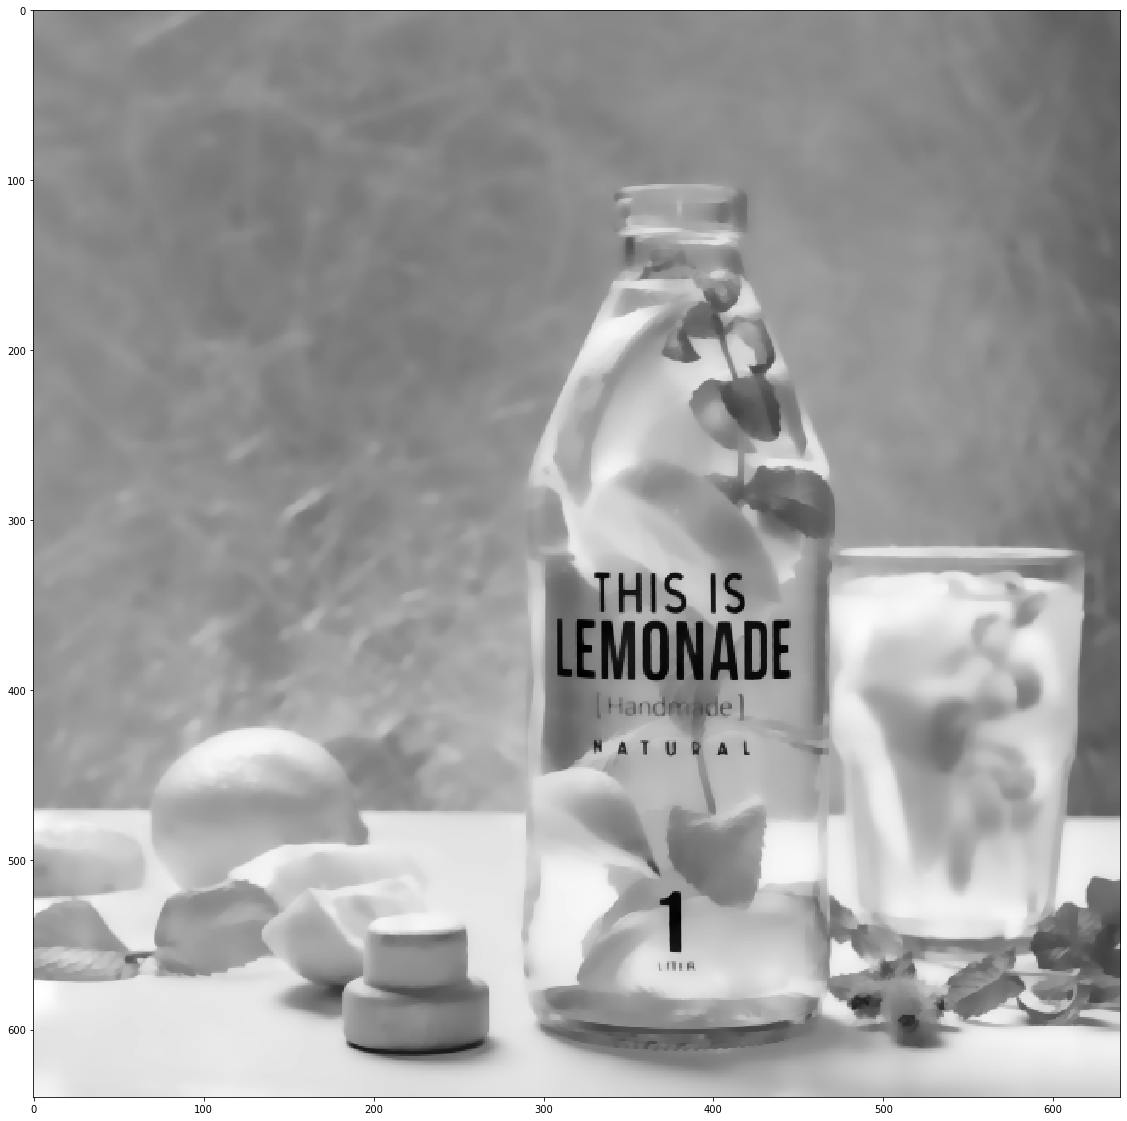

In [33]:
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_sauvola 
import numpy as np
from skimage.exposure import is_low_contrast
from skimage.exposure import adjust_gamma
from skimage import exposure
from skimage.color import rgb2hsv

from skimage import exposure
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

debug = True
cimage = imread('../sample_images/image5.jpg')
cimage = exposure.adjust_gamma(cimage, 1)

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(cimage, multichannel=True, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

# # if sigma_est > 1:
cimage = denoise_tv_chambolle(cimage, multichannel=True)
img = rgb2gray(cimage)
if debug:
    plt.figure(figsize=(20,20))
    plt.imshow(img, cmap="gray")

In [34]:
from skimage.measure import label, regionprops
from scipy.ndimage.morphology import distance_transform_edt
import time

st_time = int(round(time.time() * 1000))

@ray.remote
def remove_non_text_like_regions(image):
    ret_img = np.copy(image)
    label_image = label(image)
    img_height, img_weight = image.shape
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        height = maxr - minr
        width = maxc - minc
        aspect_ratio = width/height
        should_clean = region.area < 15 * (img_height * img_weight / (600**2))
        should_clean = should_clean or (region.area > (img_height*img_weight/5))
        should_clean = should_clean or aspect_ratio < 0.06  or aspect_ratio > 3
        should_clean = should_clean or region.eccentricity > 0.995
        should_clean = should_clean or region.solidity < 0.3
        should_clean = should_clean or region.extent < 0.2 or region.extent > 0.9

            
        strokeWidthValues = distance_transform_edt(region.image)
        flat = strokeWidthValues.flatten()
        flat = flat[flat > 0]
        coefficient_of_variation = np.std(flat)/np.mean(flat)
        should_clean = should_clean or coefficient_of_variation > 0.6
        if should_clean:
            for coord in region.coords:
                ret_img[coord[0],coord[1]] = 0
                
    return ret_img

futures = []
# thresholding the image under different thresholds
threshold_values = np.arange(0.1,0.7, 0.01)
for threshold in threshold_values:
    objId = remove_non_text_like_regions.remote(img < threshold)
    futures.append(objId)

binary_images = ray.get(futures)
ed_time = int(round(time.time() * 1000))
print("total time taken:", (ed_time - st_time))

debug = False

if debug:
    fig, ax = plt.subplots(nrows=len(threshold_values), figsize=(20,220))
    for index, bin_img in enumerate(binary_images):
        ax[index].imshow(bin_img)
    plt.show()

total time taken: 555


total time taken: 132


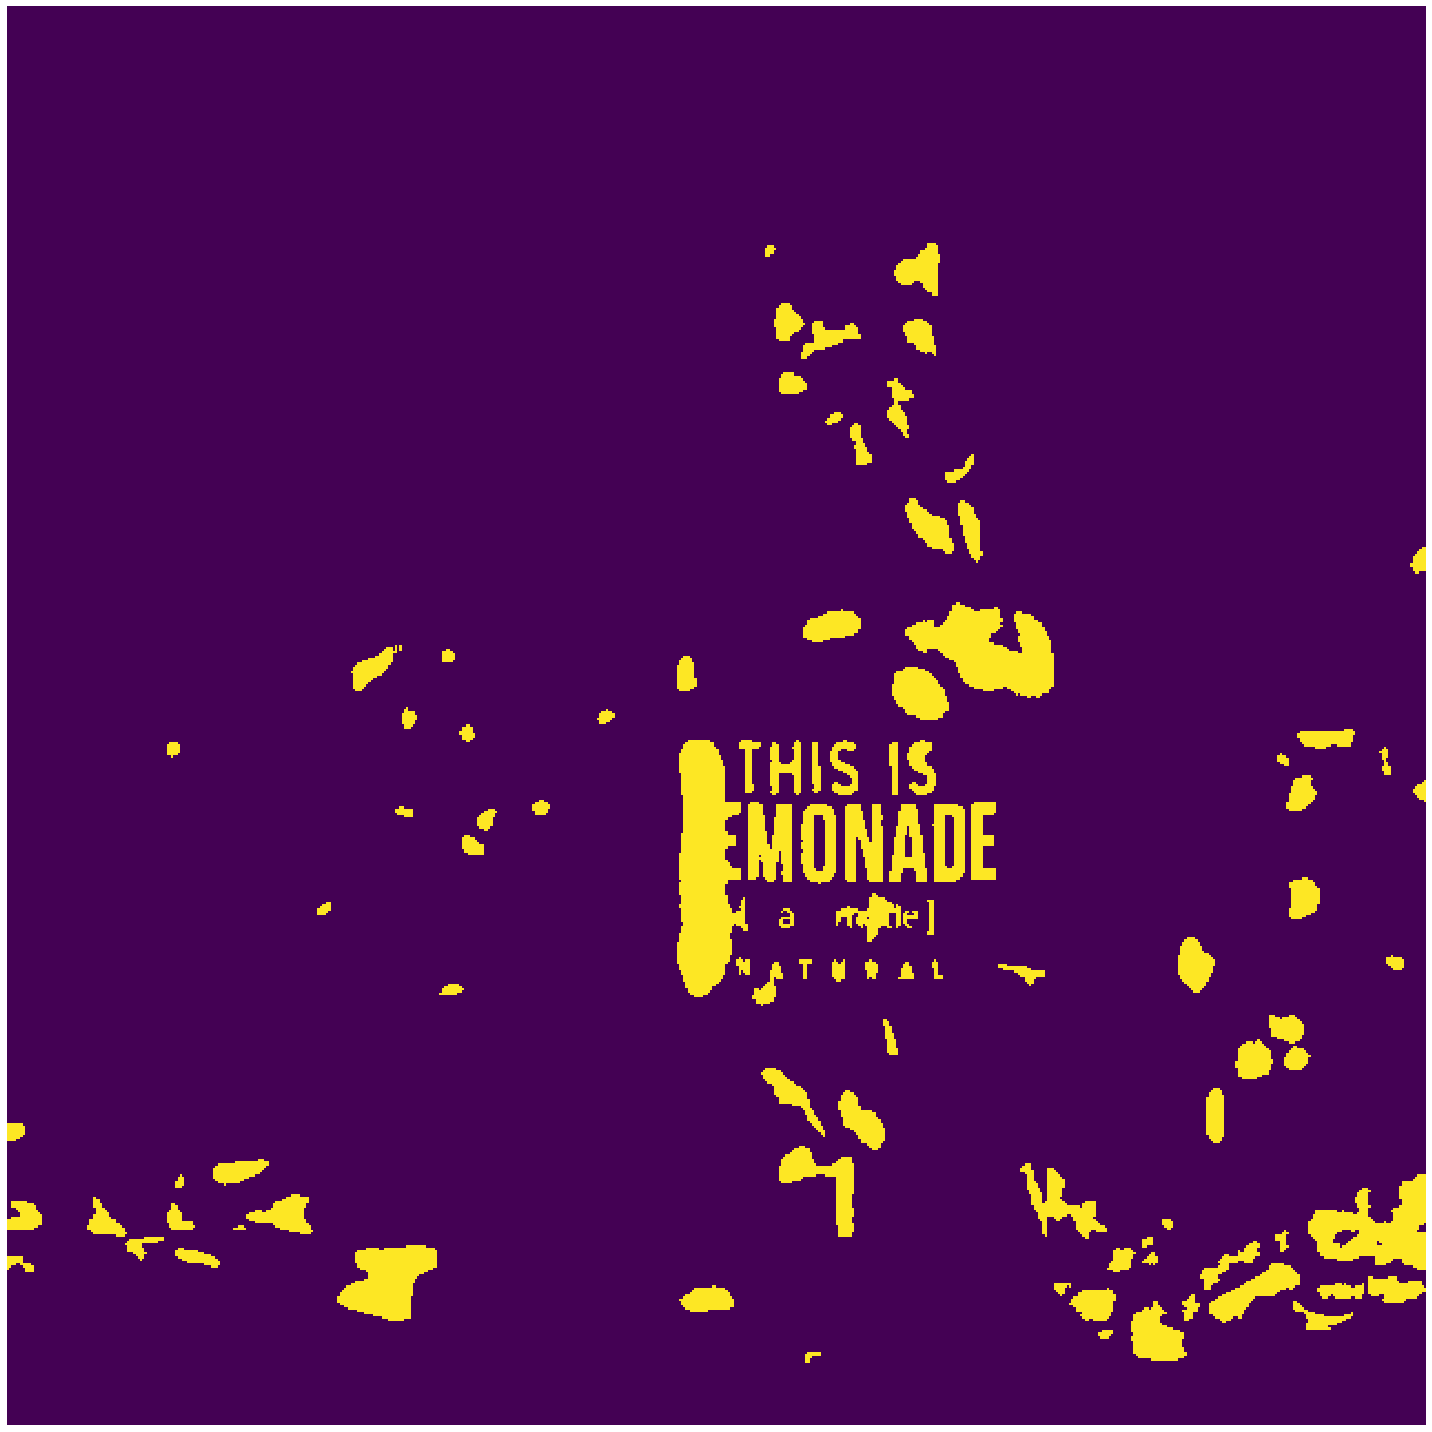

In [35]:
import matplotlib.patches as mpatches
st_time = int(round(time.time() * 1000))
layers_combined = np.zeros(img.shape)
for image in binary_images:
    label_image = label(image)
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        layers_combined[minr:maxr, minc:maxc]+=image[minr:maxr, minc:maxc]
            
ed_time = int(round(time.time() * 1000))
print("total time taken:", (ed_time - st_time))

fig, ax = plt.subplots(figsize=(20,20))

final_image = layers_combined>3
ax.imshow(final_image)
ax.set_axis_off()
plt.tight_layout()
plt.show()

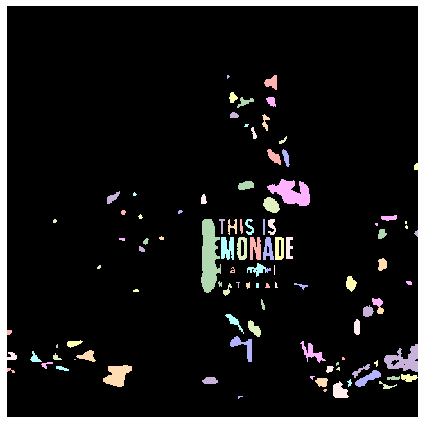

In [36]:
from skimage.color import label2rgb

# label image regions
label_image = label(final_image)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=final_image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)
ax.set_axis_off()
plt.tight_layout()
plt.show()